In [32]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [33]:
# Data used for training and testing
tickers = ['AAPL', 'GOOG', 'AMZN', 'MSFT']
stock = yf.download(tickers, start="2001-01-01", end="2015-01-01").stack()
stock.index.names = ['date', 'ticker']
stock.columns = stock.columns.str.lower()

# Data used purely for backtesting.
backtest_stocks = yf.download(tickers, start="2015-02-02", end="2025-01-01").stack()
backtest_stocks.index.names = ['date', 'ticker']
backtest_stocks.columns = stock.columns.str.lower()

backtest_stocks


[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed


Price                   close        high         low        open     volume
date       ticker                                                           
2015-02-02 AAPL     26.389219   26.509342   25.821973   26.260200  250956400
           AMZN     18.223499   18.250000   17.500500   17.502501  204638000
           GOOG     26.257307   26.481880   25.763938   26.418781   56996054
           MSFT     35.375916   35.453043   34.476093   34.784604   50352500
2015-02-03 AAPL     26.393663   26.491540   26.162315   26.360296  207662800
...                       ...         ...         ...         ...        ...
2024-12-30 MSFT    423.979858  426.694417  421.055729  425.207408   13158700
2024-12-31 AAPL    250.144974  253.001833  249.156056  252.162760   39480700
           AMZN    219.389999  223.229996  218.940002  222.970001   24819700
           GOOG    190.440002  193.250000  189.580002  192.445007   14355200
           MSFT    420.656525  425.876070  419.818209  425.247326   13246500

[9984 rows x 5 columns]

In [34]:
''' Adding only three features due the size of the dataset I am uisng. However, For this dataset using just EMA and RSI can be sufficient. '''
'''
# Calculating the Garman-Klass Volatility to capture volatility.
stock['gk_volatility'] = np.sqrt((np.log(stock['high'] / stock['low']) ** 2) / 2 - (2 * np.log(2) - 1) * (np.log(stock['close'] / stock['open']) ** 2))

# Bollinger Bands to capture price extremes.
window = 20
stock['bb_middle'] = stock['close'].rolling(window=window).mean()
stock['bb_Upper'] = stock['bb_middle'] + (2 * stock['close'].rolling(window=window).std())
stock['bb_Lower'] = stock['bb_middle'] - (2 * stock['close'].rolling(window=window).std()) '''

# Calculate EMA
stock['ema'] = stock['close'].ewm(span=20, adjust=False).mean()

# Calculating Relative Strength Index (RSI) to capture momentum.
delta = stock['close'].diff() # delta is the day-to-day difference between closing prices
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss # Relative Strength
stock['rsi'] = 100 - (100 / (1 + rs))


stock = stock.dropna()
stock

Price                  close       high        low       open       volume  \
date       ticker                                                            
2001-01-08 AMZN     0.746875   0.778125   0.687500   0.721875  208894000.0   
           MSFT    15.027012  15.276502  14.336115  15.027012   79817600.0   
2001-01-09 AAPL     0.258617   0.265435   0.249213   0.252974  588929600.0   
           AMZN     0.818750   0.831250   0.728125   0.728125  469104000.0   
           MSFT    15.909824  16.159315  15.276502  15.353268  114965400.0   
...                      ...        ...        ...        ...          ...   
2014-12-30 MSFT    40.294949  40.809132  40.140693  40.654876   16384700.0   
2014-12-31 AAPL    24.554005  25.165742  24.516189  25.096783  165613600.0   
           AMZN    15.517500  15.649000  15.500500  15.577500   40960000.0   
           GOOG    26.153963  26.462009  26.124152  26.394934   27364925.0   
           MSFT    39.806492  40.654895  39.806492  40.046444   21552500.0   

Price                    ema        rsi  
date       ticker                        
2001-01-08 AMZN     3.421890  50.228369  
           MSFT     4.527139  55.746595  
2001-01-09 AAPL     4.120613  49.847960  
           AMZN     3.806150  45.230131  
           MSFT     4.958881  55.886226  
...                      ...        ...  
2014-12-30 MSFT    27.625001  57.066705  
2014-12-31 AAPL    27.332525  49.529450  
           AMZN    26.207285  42.712087  
           GOOG    26.202206  50.232590  
           MSFT    27.497853  56.955180  

[13161 rows x 7 columns]

In [35]:
# prepping data.
stock['return'] = stock['close'].pct_change()
stock['signal'] = (stock['return'].shift(-1) > 0).astype(int) # Target => 1(if next day's return is _+ve):buy and 0:sell
stock = stock.dropna()

stock

Price                  close       high        low       open       volume  \
date       ticker                                                            
2001-01-08 MSFT    15.027012  15.276502  14.336115  15.027012   79817600.0   
2001-01-09 AAPL     0.258617   0.265435   0.249213   0.252974  588929600.0   
           AMZN     0.818750   0.831250   0.728125   0.728125  469104000.0   
           MSFT    15.909824  16.159315  15.276502  15.353268  114965400.0   
2001-01-10 AAPL     0.249213   0.255795   0.241689   0.251093  580781600.0   
...                      ...        ...        ...        ...          ...   
2014-12-30 MSFT    40.294949  40.809132  40.140693  40.654876   16384700.0   
2014-12-31 AAPL    24.554005  25.165742  24.516189  25.096783  165613600.0   
           AMZN    15.517500  15.649000  15.500500  15.577500   40960000.0   
           GOOG    26.153963  26.462009  26.124152  26.394934   27364925.0   
           MSFT    39.806492  40.654895  39.806492  40.046444   21552500.0   

Price                    ema        rsi     return  signal  
date       ticker                                           
2001-01-08 MSFT     4.527139  55.746595  19.119849       0  
2001-01-09 AAPL     4.120613  49.847960  -0.982790       1  
           AMZN     3.806150  45.230131   2.165876       1  
           MSFT     4.958881  55.886226  18.431846       0  
2001-01-10 AAPL     4.510341  49.787645  -0.984336       1  
...                      ...        ...        ...     ...  
2014-12-30 MSFT    27.625001  57.066705   0.529006       0  
2014-12-31 AAPL    27.332525  49.529450  -0.390643       0  
           AMZN    26.207285  42.712087  -0.368026       1  
           GOOG    26.202206  50.232590   0.685450       1  
           MSFT    27.497853  56.955180   0.522006       0  

[13160 rows x 9 columns]

In [36]:
# defining Feature list and Target. 
X = stock[['ema', 'rsi']]
y = stock['signal']

# 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [37]:
# Initialize the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [38]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")


Model Accuracy: 0.9680851063829787


In [39]:
''' Apply model to backtesting data: Adding idential features to generate predictions on unseen data.'''


features = ['ema', 'rsi']

'''
# Calculating the Garman-Klass Volatility to capture volatility.
backtest_stocks['gk_volatility'] = np.sqrt((np.log(backtest_stocks['high'] / backtest_stocks['low']) ** 2) / 2 - (2 * np.log(2) - 1) * (np.log(backtest_stocks['close'] / backtest_stocks['open']) ** 2))

# Bollinger Bands to capture price extremes.
window = 20
backtest_stocks['bb_middle'] = backtest_stocks['close'].rolling(window=window).mean()
backtest_stocks['bb_Upper'] = backtest_stocks['bb_middle'] + (2 * backtest_stocks['close'].rolling(window=window).std())
backtest_stocks['bb_Lower'] = backtest_stocks['bb_middle'] - (2 * backtest_stocks['close'].rolling(window=window).std())
'''
# Calculating Relative Strength Index (RSI) to capture momentum.
delta = backtest_stocks['close'].diff() # delta is the day-to-day difference between closing prices
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss # Relative Strength
backtest_stocks['rsi'] = 100 - (100 / (1 + rs))

# Calculate EMA
backtest_stocks['ema'] = backtest_stocks['close'].ewm(span=20, adjust=False).mean()

backtest_stocks = backtest_stocks.dropna()
backtest_stocks['Predicted_Signal'] = model.predict(backtest_stocks[features])
backtest_stocks['return'] = backtest_stocks['close'].pct_change()

backtest_stocks

C:\Users\harsi\AppData\Local\Temp\ipykernel_12396\1289994330.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_stocks['Predicted_Signal'] = model.predict(backtest_stocks[features])
C:\Users\harsi\AppData\Local\Temp\ipykernel_12396\1289994330.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_stocks['return'] = backtest_stocks['close'].pct_change()


Price                   close        high         low        open     volume  \
date       ticker                                                              
2015-02-05 AMZN     18.694500   18.940001   18.295000   18.299999  144952000   
           GOOG     26.212589   26.258301   25.939821   26.024286   36995292   
           MSFT     36.378574   36.541398   35.872959   36.181471   36548200   
2015-02-06 AAPL     26.560362   26.855154   26.453164   26.803788  174826400   
           AMZN     18.714001   18.799500   18.550501   18.743500   77848000   
...                       ...         ...         ...         ...        ...   
2024-12-30 MSFT    423.979858  426.694417  421.055729  425.207408   13158700   
2024-12-31 AAPL    250.144974  253.001833  249.156056  252.162760   39480700   
           AMZN    219.389999  223.229996  218.940002  222.970001   24819700   
           GOOG    190.440002  193.250000  189.580002  192.445007   14355200   
           MSFT    420.656525  425.876070  419.818209  425.247326   13246500   

Price                    rsi         ema  Predicted_Signal    return  
date       ticker                                                     
2015-02-05 AMZN    46.570414   26.095736                 0       NaN  
           GOOG    49.926219   26.106865                 1  0.402155  
           MSFT    57.458957   27.085123                 0  0.387828  
2015-02-06 AAPL    50.122710   27.035146                 1 -0.269890  
           AMZN    43.183191   26.242656                 1 -0.295416  
...                      ...         ...               ...       ...  
2024-12-30 MSFT    55.730080  282.677741                 0  1.200321  
2024-12-31 AAPL    51.426118  279.579382                 0 -0.410007  
           AMZN    43.293361  273.847060                 1 -0.122949  
           GOOG    47.696453  265.903531                 0 -0.131957  
           MSFT    55.758912  280.641911                 0  1.208866  

[9971 rows x 9 columns]

In [40]:
# Comparission and plotting 
# Convert the index to datetime if not already
#backtest_stocks.index = pd.to_datetime(backtest_stocks.index)

# calculating the returns from the model: if signal = 1 we take the return(loss or gain) for the day, else we do nothing. 
# shifting by one to ensure that only past predictions affect the future.
backtest_stocks['strategy_return'] = backtest_stocks['Predicted_Signal'].shift(1) * backtest_stocks['return']

# This represents the compunded growth of investing 1 dollar, following the models's predictions.
backtest_stocks['Cumulative_Strategy_Return'] = (1 + backtest_stocks['strategy_return']).cumprod()

# This represents the compunded growth of investing 1 dollar, following the buy-hold statergy.
backtest_stocks['Cumulative_Stock_Return'] = (1 + backtest_stocks['return']).cumprod()
backtest_stocks




C:\Users\harsi\AppData\Local\Temp\ipykernel_12396\2916122683.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_stocks['strategy_return'] = backtest_stocks['Predicted_Signal'].shift(1) * backtest_stocks['return']
C:\Users\harsi\AppData\Local\Temp\ipykernel_12396\2916122683.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_stocks['Cumulative_Strategy_Return'] = (1 + backtest_stocks['strategy_return']).cumprod()
C:\Users\harsi\AppData\Local\Temp\ipykernel_12396\2916122683.py:13: SettingW

Price                   close        high         low        open     volume  \
date       ticker                                                              
2015-02-05 AMZN     18.694500   18.940001   18.295000   18.299999  144952000   
           GOOG     26.212589   26.258301   25.939821   26.024286   36995292   
           MSFT     36.378574   36.541398   35.872959   36.181471   36548200   
2015-02-06 AAPL     26.560362   26.855154   26.453164   26.803788  174826400   
           AMZN     18.714001   18.799500   18.550501   18.743500   77848000   
...                       ...         ...         ...         ...        ...   
2024-12-30 MSFT    423.979858  426.694417  421.055729  425.207408   13158700   
2024-12-31 AAPL    250.144974  253.001833  249.156056  252.162760   39480700   
           AMZN    219.389999  223.229996  218.940002  222.970001   24819700   
           GOOG    190.440002  193.250000  189.580002  192.445007   14355200   
           MSFT    420.656525  425.876070  419.818209  425.247326   13246500   

Price                    rsi         ema  Predicted_Signal    return  \
date       ticker                                                      
2015-02-05 AMZN    46.570414   26.095736                 0       NaN   
           GOOG    49.926219   26.106865                 1  0.402155   
           MSFT    57.458957   27.085123                 0  0.387828   
2015-02-06 AAPL    50.122710   27.035146                 1 -0.269890   
           AMZN    43.183191   26.242656                 1 -0.295416   
...                      ...         ...               ...       ...   
2024-12-30 MSFT    55.730080  282.677741                 0  1.200321   
2024-12-31 AAPL    51.426118  279.579382                 0 -0.410007   
           AMZN    43.293361  273.847060                 1 -0.122949   
           GOOG    47.696453  265.903531                 0 -0.131957   
           MSFT    55.758912  280.641911                 0  1.208866   

Price              strategy_return  Cumulative_Strategy_Return  \
date       ticker                                                
2015-02-05 AMZN                NaN                         NaN   
           GOOG           0.000000                    1.000000   
           MSFT           0.387828                    1.387828   
2015-02-06 AAPL          -0.000000                    1.387828   
           AMZN          -0.295416                    0.977841   
...                            ...                         ...   
2024-12-30 MSFT           0.000000                    0.000613   
2024-12-31 AAPL          -0.000000                    0.000613   
           AMZN          -0.000000                    0.000613   
           GOOG          -0.131957                    0.000532   
           MSFT           0.000000                    0.000532   

Price              Cumulative_Stock_Return  
date       ticker                           
2015-02-05 AMZN                        NaN  
           GOOG                   1.402155  
           MSFT                   1.945951  
2015-02-06 AAPL                   1.420758  
           AMZN                   1.001043  
...                                    ...  
2024-12-30 MSFT                  22.679390  
2024-12-31 AAPL                  13.380672  
           AMZN                  11.735537  
           GOOG                  10.186954  
           MSFT                  22.501619  

[9971 rows x 12 columns]

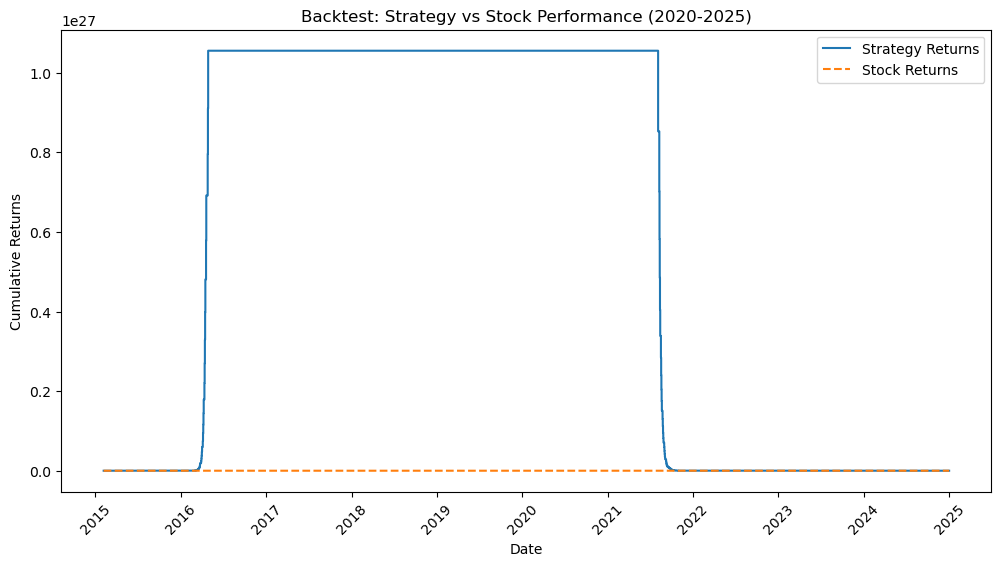

In [41]:
index_tuples = backtest_stocks.index.tolist()
dates = [item[0] for item in index_tuples]
tickers = [item[1] for item in index_tuples]

plt.figure(figsize=(12, 6))
plt.plot(dates, backtest_stocks['Cumulative_Strategy_Return'], label='Strategy Returns', linestyle='-')
plt.plot(dates, backtest_stocks['Cumulative_Stock_Return'], label='Stock Returns', linestyle='--')
plt.legend()
plt.title('Backtest: Strategy vs Stock Performance (2020-2025)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.xticks(rotation=45)
plt.show()